In [2]:
install.packages(c("dplyr", "glmnet", "zoo", "lubridate"))


Installing packages into ‘/home/codespace/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [1]:
library(dplyr)
library(glmnet)
library(zoo)
library(lubridate)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loaded glmnet 4.1-10


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
clean_oil_data = function(filename) {
  read.csv2(filename) %>% 
    filter(!is.na(Date)) %>% 
    # put Date into dateformat
    mutate(Date = as.Date(Date, "%d.%m.%Y")) %>% 
    # put all other variables into numer format
    mutate(across(-Date, ~ as.numeric(as.character(.))))
}

files = list(
  "Industry_D.csv", 
  "Industry_M.csv", 
  "Industry_W.csv", 
  "Macro_M.csv", 
  "StockPrices_M.csv"
)

cleaned_data = lapply(files, clean_oil_data)

industry_d = cleaned_data[[1]]
industry_m = cleaned_data[[2]] %>% 
# these variables already appear inside industry_d
  select(-any_of(c("CL1", "CL2", "Brent", "CRKS321C.Index", "Baltic.Dry.Index", "datadate")))
industry_w = cleaned_data[[3]]
macro_m = cleaned_data[[4]]
stockprices_m = cleaned_data[[5]]

head(industry_d)
head(industry_m)

,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2024-07-30,74.73,73.88,78.63,21.883,1762
2,2024-07-29,75.81,74.80,79.78,22.171,1797
3,2024-07-26,77.16,76.00,81.13,21.071,1808
4,2024-07-25,78.28,77.11,82.37,20.832,1834
5,2024-07-24,77.59,76.58,81.71,19.776,1864
6,2024-07-23,76.96,75.92,81.01,21.118,1869


,Date,Daily.Production,Inventories,Rig.Count,Commercial.Long,Commercial.Short,Total.Open.Interest,X,X.1,X.2,X.3
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2024-06-28,13200,821134,581,1600085,1631509,3231594,NA,NA,NA,NA
2,2024-05-31,13100,826109,600,1750160,1785108,3535268,NA,NA,NA,NA
3,2024-04-30,13100,827161,613,1708427,1751709,3460136,NA,NA,NA,NA
4,2024-03-29,13100,815058,621,1687838,1725350,3413188,NA,NA,NA,NA
5,2024-02-29,13300,807417,626,1583286,1606750,3190036,NA,NA,NA,NA
6,2024-01-31,13000,779314,621,1673204,1695615,3368819,NA,NA,NA,NA


In [3]:
# set a grid for the date range
date_grid = data.frame(
  Date = seq(
    from = min(
      industry_d$Date,
      industry_w$Date,
      industry_m$Date,
      macro_m$Date,
      stockprices_m$Date,
      na.rm = TRUE
    ),
    to = max(
      industry_d$Date,
      industry_w$Date,
      industry_m$Date,
      macro_m$Date,
      stockprices_m$Date,
      na.rm = TRUE
    ),
    by = "day"
  )
)


In [4]:
# merge the data
data_merged = date_grid %>%
  left_join(industry_d, by = "Date") %>%
  left_join(industry_w, by = "Date") %>%
  left_join(industry_m, by = "Date") %>%
  left_join(macro_m, by = "Date") %>%
  left_join(stockprices_m, by = "Date") %>%
  arrange(Date)


head(data_merged)
tail(data_merged)
print(paste("Rows after merge:", nrow(data_merged)))

,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1990-01-02,22.89,22.41,21.95,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1990-01-03,23.68,22.97,23.48,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1990-01-04,23.41,22.53,26.78,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1990-01-05,23.08,22.03,27.40,NA,NA,7512,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1990-01-06,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1990-01-07,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12624,2024-07-25,78.28,77.11,82.37,20.832,1834,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12625,2024-07-26,77.16,76.00,81.13,21.071,1808,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12626,2024-07-27,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12627,2024-07-28,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12628,2024-07-29,75.81,74.80,79.78,22.171,1797,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12629,2024-07-30,74.73,73.88,78.63,21.883,1762,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "Rows after merge: 12629"


In [15]:
data_merged_filled = data_merged %>%
  arrange(Date) %>%
  mutate(across(-Date, ~ zoo::na.locf(., na.rm = FALSE))) %>% 
  mutate(across(-Date, ~ zoo::na.locf(., fromLast = TRUE, na.rm = FALSE)))

head(data_merged_filled)  # earliest dates
tail(data_merged_filled)  # latest dates
print(paste("Rows after filling:", nrow(data_merged_filled)))

print(paste("Variables in dataset:", paste(names(data_merged_filled), collapse = ", ")))


,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1990-01-02,22.89,22.41,21.95,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
2,1990-01-03,23.68,22.97,23.48,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
3,1990-01-04,23.41,22.53,26.78,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
4,1990-01-05,23.08,22.03,27.40,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
5,1990-01-06,23.08,22.03,27.40,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
6,1990-01-07,23.08,22.03,27.40,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116


,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12624,2024-07-25,78.28,77.11,82.37,20.832,1834,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12625,2024-07-26,77.16,76.00,81.13,21.071,1808,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12626,2024-07-27,77.16,76.00,81.13,21.071,1808,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12627,2024-07-28,77.16,76.00,81.13,21.071,1808,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12628,2024-07-29,75.81,74.80,79.78,22.171,1797,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12629,2024-07-30,74.73,73.88,78.63,21.883,1762,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68


[1] "Rows after filling: 12629"
[1] "Variables in dataset: Date, CL1, CL2, Brent, CRKS321C.Index, BDIY.Index, Weekly.Prod.Crude, Weekly.Rig.Count, Weekly.change.in.Crude.Stock, Weekly.Commercial.Long, Weekly.Commercial.Short, Weekly.Total.Open.Interest, Daily.Production, Inventories, Rig.Count, Commercial.Long, Commercial.Short, Total.Open.Interest, X, X.1, X.2, X.3, CPI.YOY.., X3M.Yield, X10Y.Yield, IndustrialProduction.Index, SPX, DXY.returns, VIX, Gasoline.All.Grades, Dow.Jones.US.Oil.Gas.Index, ExxonMobil, ConocoPhilips, Chevron, BP, Shell, TotalEnergies"


## 1. Build the complete table

In [41]:
# --- define variable groups ---
price_vars = c("CL1", "CL2", "Brent", "CRKS321C.Index", "BDIY.Index", "SPX", 
               "Gasoline.All.Grades", "Dow.Jones.US.Oil.Gas.Index", "ExxonMobil", 
               "ConocoPhilips", "Chevron", "BP", "Shell", "TotalEnergies")

macro_diff_vars = c("CPI.YOY..", "X3M.Yield", "X10Y.Yield", 
                   "IndustrialProduction.Index", "DXY.returns", "VIX")

quantity_diff_vars = c("Daily.Production", "Inventories", "Rig.Count", 
                      "Commercial.Long", "Commercial.Short", "Total.Open.Interest")

# --- create transformed dataset with a Forward Target ---
data_merged_final = data_merged_filled %>%
  arrange(Date) %>%
  mutate(
    # Daily Log Returns for standard predictors
    across(all_of(price_vars), ~ log(.) - log(lag(.)), .names = "{.col}_log_ret"),
    
    # NEW: Forward 5-Day Return (The Trend Midline)
    # We use align="left" to see the NEXT 5 days from 'today'
    CL1_fwd_5d = zoo::rollapply(CL1_log_ret, width = 5, FUN = sum, align = "left", fill = NA),
    
    # Differences for Sparse Variables
    across(all_of(c(macro_diff_vars, quantity_diff_vars)), ~ . - lag(.), .names = "{.col}_diff")
  )

# --- Generate Cumulative Memory ---
diff_cols = names(data_merged_final)[grepl("_diff$", names(data_merged_final))]

for(col in diff_cols) {
  data_merged_final[[paste0(col, "_5d")]] = zoo::rollapplyr(data_merged_final[[col]], 5, sum, fill = 0)
  data_merged_final[[paste0(col, "_22d")]] = zoo::rollapplyr(data_merged_final[[col]], 22, sum, fill = 0)
  data_merged_final[[paste0(col, "_65d")]] = zoo::rollapplyr(data_merged_final[[col]], 65, sum, fill = 0)
}

# Keep observations where BOTH target and standard returns are defined
data_merged_final = data_merged_final %>% filter(!is.na(CL1_fwd_5d) & !is.na(CL1_log_ret))

Warning message:
“There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(all_of(price_vars), ~log(.) - log(lag(.)), .names =
  "{.col}_log_ret")`.
Caused by warning in `log()`:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”


In [42]:
# split the data. first economic cycle of 10 years completes EOY 2000
IS_data = data_merged_final %>%
    filter(Date <= as.Date("2000-12-31"))
OoS_data = data_merged_final %>%
    filter(Date > as.Date("2000-12-31"))

## 2. Standardize

In [43]:
# Focus on log returns and the three memory horizons
predictors_initial = names(data_merged_final)[grepl("_log_ret$|_5d$|_22d$|_65d$", names(data_merged_final))]
predictors_initial = setdiff(predictors_initial, c("CL1_log_ret", "CL2_log_ret", "Brent_log_ret", "CL1_fwd_5d"))

# Remove zero-variance predictors
is_sds_check = apply(IS_data[, predictors_initial], 2, sd, na.rm = TRUE)
dead_cols = names(is_sds_check)[is_sds_check == 0 | is.na(is_sds_check)]
predictors = setdiff(predictors_initial, dead_cols)

# Scale
is_means = colMeans(IS_data[, predictors], na.rm = TRUE)
is_sds   = apply(IS_data[, predictors], 2, sd, na.rm = TRUE)

IS_data_scaled  = IS_data
OoS_data_scaled = OoS_data

IS_data_scaled[, predictors] = scale(IS_data[, predictors], center = is_means, scale = is_sds)
OoS_data_scaled[, predictors] = scale(OoS_data[, predictors], center = is_means, scale = is_sds)

# Remove any remaining NAs
IS_data_scaled = IS_data_scaled[complete.cases(IS_data_scaled[, predictors]), ]
OoS_data_scaled = OoS_data_scaled[complete.cases(OoS_data_scaled[, predictors]), ]

## 3. LASSO

[1] "Variables that explain the 1-week trend:"
                                  Variable  Coefficient
4128              Inventories_diff_22d_L90 -0.002585138
3164                 Rig.Count_diff_5d_L69  0.002346461
1491               X10Y.Yield_diff_22d_L33  0.002122563
3797              DXY.returns_diff_22d_L83  0.002100762
3017                       VIX_diff_5d_L66 -0.001992121
361             Commercial.Long_diff_5d_L8  0.001670261
2487                BDIY.Index_log_ret_L55 -0.001602218
729            Commercial.Long_diff_5d_L16  0.001594878
2244                 Rig.Count_diff_5d_L49 -0.001585670
2190                      VIX_diff_22d_L48 -0.001421501
21   IndustrialProduction.Index_diff_5d_L1  0.001323450
3526          Daily.Production_diff_5d_L77  0.001298227
981                  X3M.Yield_diff_5d_L22 -0.001258607
1743          Commercial.Long_diff_65d_L38 -0.001195023
2933              Inventories_diff_65d_L64  0.001170332
3784                 CPI.YOY.._diff_5d_L83 -0.001142220
1

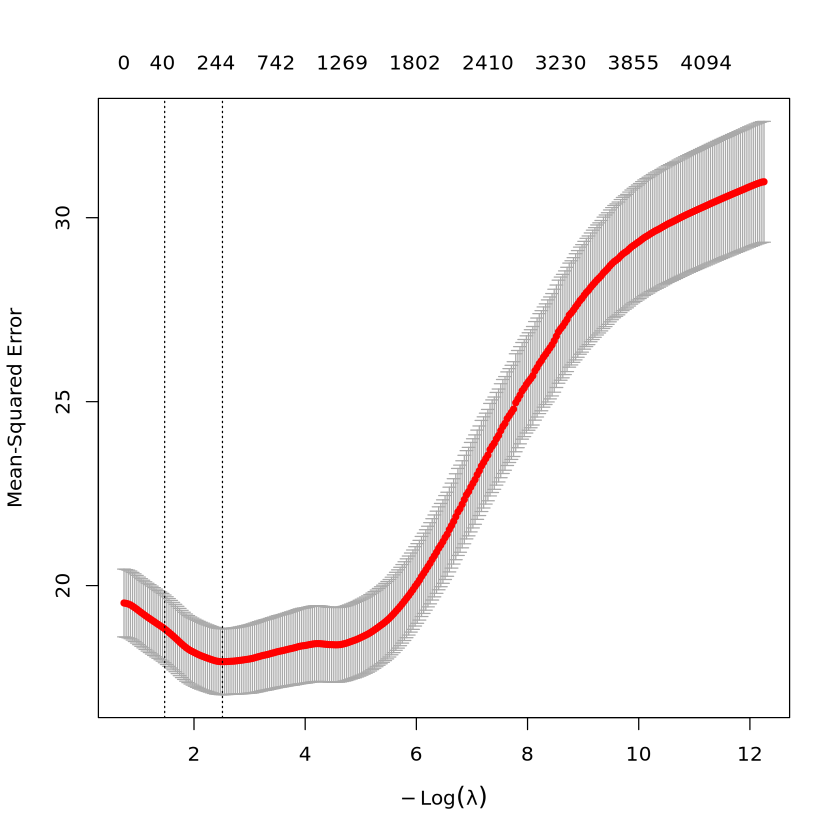

: 

In [ ]:
max_lag = 90
IS_lags = list(); OoS_lags = list()

for (i in 1:max_lag) {
  IS_lags[[i]] = as.data.frame(lapply(IS_data_scaled[, predictors], function(x) c(rep(NA, i), head(x, -i))))
  OoS_lags[[i]] = as.data.frame(lapply(OoS_data_scaled[, predictors], function(x) c(rep(NA, i), head(x, -i))))
  
  colnames(IS_lags[[i]]) = paste0(predictors, "_L", i)
  colnames(OoS_lags[[i]]) = paste0(predictors, "_L", i)
}

IS_huge = cbind(IS_data_scaled, do.call(cbind, IS_lags))
OoS_huge = cbind(OoS_data_scaled, do.call(cbind, OoS_lags))

IS_huge = IS_huge[(max_lag + 1):nrow(IS_huge), ]
OoS_huge = OoS_huge[(max_lag + 1):nrow(OoS_huge), ]

# Prepare matrices
lagged_predictors = names(IS_huge)[grepl("_L[0-9]+$", names(IS_huge))]
x_train = as.matrix(IS_huge[, lagged_predictors])
y_train = IS_huge$CL1_fwd_5d * 100 

set.seed(123)
cv_lasso = cv.glmnet(x_train, y_train, alpha = 1, standardize = FALSE, nlambda = 300, lambda.min.ratio = 1e-5)

plot(cv_lasso)

# Rescale coefficients back to decimal
coefs = coef(cv_lasso, s = "lambda.min")
coef_df = data.frame(Variable = rownames(coefs), Coefficient = as.numeric(coefs))
coef_df = coef_df[coef_df$Variable != "(Intercept)" & coef_df$Coefficient != 0, ]
coef_df$Coefficient = coef_df$Coefficient / 100
coef_df = coef_df[order(-abs(coef_df$Coefficient)), ]

print("Variables that explain the 1-week trend:")
print(head(coef_df, 20))